<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-dependency" data-toc-modified-id="Import-dependency-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import dependency</a></span></li><li><span><a href="#Define-a-natural-cubic-spline-features-transformer" data-toc-modified-id="Define-a-natural-cubic-spline-features-transformer-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Define a natural cubic spline features transformer</a></span></li><li><span><a href="#Load-data-and-fit" data-toc-modified-id="Load-data-and-fit-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Load data and fit</a></span></li><li><span><a href="#Plot-each-term-with-point-wise-variance" data-toc-modified-id="Plot-each-term-with-point-wise-variance-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Plot each term with point-wise variance</a></span></li></ul></div>

In [8]:
from IPython.display import display, HTML, Image
display(HTML("<style>.container { width:75% !important; }</style>"))

# Import dependency
- [ref](https://github.com/empathy87/The-Elements-of-Statistical-Learning-Python-Notebooks/blob/master/examples/South%20African%20Heart%20Disease.ipynb)

In [104]:
import itertools
import numpy as np
from matplotlib import transforms, pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
import statsmodels.api as sm
from scipy import stats
from typing import List

%matplotlib notebook

# Define a natural cubic spline features transformer

From the Section 5.2.1, the natural cubic spline formula (5.4) and (5.5) are as following:

$$N_1(X)=1, N_2(X)=X,N_{k+2}(X)=d_k(X)-d_{K-1}(X), k=1,2,\cdots,K-2$$

where
$$d_k(X)=\frac{(X-\xi_k)^3_{+}-(X-\xi_K)^3_{+}}{\xi_K-\xi_k}$$

In [59]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """ Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components.
    """

    def __init__(
        self,
        knots: List[List[float]] = None,
        target_dofs: int = None,
        add_interactions: bool = False
    ):
        self.knots = knots
        self.target_dofs = target_dofs
        self.add_interactions = add_interactions
        self.dofs_ = None
        self.positions_ = None

    def fit(self, X: np.ndarray, y: np.array = None) -> 'NaturalCubicSplineFeatures':
        """ Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.

        Here, we just calculate the knots positions. The heavy-lifting natural 
        cubic spline generation is in the `transform` method. We don't need y here.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs+1)
            self.knots = [
                np.unique(np.quantile(X[:, i], quantiles))
                for i in range(X.shape[1])
            ]
        # Calculate the number of functions in each component term (constant function excluded)
        self.dofs_ = np.array([len(knots)-1 for knots in self.knots])
        # Calculate the first and last index (excluded) of functions for each term
        dofs_cumsum = np.cumsum(self.dofs_)
        self.positions_ = [
            (0 if i == 0 else dofs_cumsum[i-1], lp)
            for i, lp in enumerate(dofs_cumsum)
        ]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """ Transform data to natural cubic spline basis expansion.
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        if self.knots is None:
            return X.copy()

        base_spline_features = [
            self.__expand_natural_cubic(X[:, i:i+1], knots)
            for i, knots in enumerate(self.knots)
        ]

        if self.add_interactions:
            self.__add_two_way_interaction_features(base_spline_features)

        return np.hstack(base_spline_features)

    @staticmethod
    def __dk(X: np.ndarray, x: float, lx: float) -> np.ndarray:
        return ((X-x).clip(0)**3-(X-lx).clip(0)**3)/(lx-x)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: List[float]) -> np.ndarray:
        natural_cubic_splines = [X.copy()]
        last_dk = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for x in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, x, knots[-1])
            natural_cubic_splines.append(dk-last_dk)
        return np.hstack(natural_cubic_splines)

    @staticmethod
    def __add_two_way_interaction_features(feature_expensions: List[np.ndarray]) -> None:
        orig_num_feature_grps = len(feature_expensions)
        for i in range(orig_num_feature_grps-1):
            for j in range(i+1, orig_num_feature_grps):
                two_way_interactions = []
                feature_indices_i = list(range(feature_expensions[i].shape[1]))
                feature_indices_j = list(range(feature_expensions[j].shape[1]))
                for ki, kj in itertools.product(*[feature_indices_i, feature_indices_j]):
                    two_way_interactions.append(
                        feature_expensions[i][ki]*feature_expensions[j][kj]
                    )
                feature_expensions.append(np.hstack(two_way_interactions))

In [56]:
# PAGE 146. We use four natural spline bases for each term in the model. For
#           example, with X1 representing sbp, h1(X1) is a basis consisting of
#           four basis functions. This actually implies three rather than two
#           interior knots (chosen at uniform quantiles of sbp), plus two
#           boundary knots at the extremes of the data, since we exclude the
#           constant term from each of the hj.

In [61]:
ncs_features = NaturalCubicSplineFeatures(target_dofs=4)
# sm.add_constant adds the constant column at the beginning.
add_intercept = FunctionTransformer(lambda X: sm.add_constant(X), validate=True)
data_prep_pipeline = Pipeline([
    ('scale_features', StandardScaler()),
    ('expand_basis', ncs_features),
    ('scale_basis', StandardScaler()),
    ('add_intercept_col', add_intercept)
])

In [39]:
# PAGE 146. At this point the model is like any other linear logistic model,
#           and the algorithms described in Section 4.4.1 apply

In [62]:
lr = LogisticRegression(solver='lbfgs', max_iter=100000, C=1e10, fit_intercept=False) # fit_intercept=False b/c we already added the constant column.
expanded_lr = Pipeline([
    ('preprocessing', data_prep_pipeline),
    ('logistic', lr)
])

In [41]:
# PAGE 146. We carried out a backward stepwise deletion process, dropping terms
#           from this model while preserving the group structure of each term,
#           rather than dropping one coefficient at a time. The AIC statistic
#           (Section 7.5) was used to drop terms, and all the terms remaining
#           in the final model would cause AIC to increase if deleted from the
#           model (see Table 5.1).

In [75]:
# calculates AIC of log-reg model trained on expanded features subset
def fit_with_features_and_get_aic(X, feature_ids):
    X_selected = X[:, sorted(feature_ids)]
    # expand the basis of the selected features
    X_selected_exp = data_prep_pipeline.fit_transform(X_selected)
    # fit the log-reg model to the expanded data and calculate its AIC
    lr = sm.Logit(y, X_selected_exp).fit_regularized(method='l1', maxiter=1000, disp=False)
    return lr.aic


In [76]:
# calculated total deviance of a model on a data set
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)

# calculates total deviance of a model trained on features subset
def fit_with_features_and_get_deviance(X, model, feature_ids):
    X_selected = X[:, sorted(list(feature_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)


# Load data and fit

In [77]:
# load training and test data set from a text file
df = pd.read_csv("../data/South_African_Heart_Disease.txt")
# encode famhist with dummy 0-1 variable
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
# convert data to X, y np.arrays
X, y = df[features].values, df[target].values
df[features + [target]].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,True,25.30,97.20,52,1
1,144,0.01,4.41,False,28.87,2.06,63,1
2,118,0.08,3.48,True,29.14,3.81,46,0
3,170,7.50,6.41,True,31.99,24.26,58,1
4,134,13.60,3.50,True,25.99,57.34,49,1


In [81]:
(
    fit_with_features_and_get_deviance(X, lr, selected_ids),
    fit_with_features_and_get_deviance(X, expanded_lr, selected_ids)
)

(502.22031807465316, 459.59557962535496)

In [80]:
# start with all features selected, store indices
selected_ids = set(range(len(features)))
current_aic = fit_with_features_and_get_aic(X, selected_ids)
current_deviance = fit_with_features_and_get_deviance(X, expanded_lr, selected_ids)
# backward stepwise
s_cnt = 0
while True:
    stat_info = [
        (
            fit_with_features_and_get_aic(X, selected_ids - set([idx])),
            fit_with_features_and_get_deviance(X, expanded_lr, selected_ids - set([idx])),
            idx
        )
        for idx in selected_ids
    ]
    min_aic, dev, feature_to_remove_idx = min(stat_info)
    if min_aic > current_aic:
        print(f"The min_aic is larger than the current_aic: {min_aic}, {current_aic} (step {s_cnt})")
        break
    else:
        print(f"The min_aic is not larger than the current_aic: {min_aic}, {current_aic} (step {s_cnt})")
    selected_ids -= set([feature_to_remove_idx])
    current_aic, current_deviance = min_aic, dev
    print(f'Remove: {features[feature_to_remove_idx]} (step: {s_cnt})')
    s_cnt += 1
    
selected_ids = sorted(list(selected_ids))
# convert list of stat_info to dictionary
stat_info = {idx: (aic, dev) for (aic, dev, idx) in stat_info}

The min_aic is not larger than the current_aic: 503.52695625235174, 511.3432494554604 (step 0)
Remove: alcohol (step: 0)
The min_aic is larger than the current_aic: 503.92795458217165, 503.52695625235174 (step 1)


In [82]:
# refit the model to the selected features
X_selected = X[:, selected_ids]
expanded_lr.fit(X_selected, y)
# save min-max of the selected features to use in plotting
X_min, X_max = np.min(X_selected, axis=0), np.max(X_selected, axis=0)

In [83]:
print(f'    Terms   Df   Deviance      AIC      LRT   P-value')
print(f'-----------------------------------------------------')
print(f'     none          {current_deviance:.2f}   {current_aic:.2f}')
for i, feature_idx in enumerate(selected_ids):
    feature_aic, feature_dev = stat_info[feature_idx]
    lrt = feature_dev - current_deviance
    p_value = 1 - stats.chi2.cdf(lrt, df=ncs_features.dofs_[i])
    print(
        f'{features[feature_idx]:>9}{ncs_features.dofs_[i]:>4}'
        f'{feature_dev:>12.2f}{feature_aic:9.2f}{lrt:>9.3f} {p_value:9.3f}'
    )

    Terms   Df   Deviance      AIC      LRT   P-value
-----------------------------------------------------
     none          459.60   503.53
      sbp   4      469.39   505.33    9.791     0.044
  tobacco   4      470.61   506.48   11.014     0.026
      ldl   4      474.64   510.48   15.045     0.005
  famhist   1      480.41   522.38   20.811     0.000
  obesity   4      467.99   503.93    8.390     0.078
      age   4      485.77   521.77   26.170     0.000


# Plot each term with point-wise variance

**PAGE 146.** Figure 5.4 shows a plot of the final model selected by the stepwise regression. The functions displayed are $\hat{f}_j(X_j) = h_j(X_j)^T\hat{\theta}_j$ for each variable $X_j$. The covariance matrix $Cov(\hat{\theta}) = \boldsymbol{\Sigma}$ is estimated by $\hat{\boldsymbol{\Sigma}}= (\boldsymbol{X}^T\boldsymbol{W}\boldsymbol{X})^{-1}$, where $\boldsymbol{W}$ is the diagonal weight matrix from the logistic regression [$w_{ii} = \pi_{i}(1-\pi_{i})$]. Hence $v_j(X_j) = Var[\hat{f}_j(X_j)] = h_j(X_j)^T\boldsymbol{\Sigma}_{jj}h_j(X_j)$ is the pointwise variance function of $\hat{f}_j$, where $Cov(\hat{\theta}_j) = \hat{\boldsymbol{\Sigma}}_{jj}$ is the appropriate sub-matrix of $\hat{\boldsymbol{\Sigma}}$. The shaded region in each panel is defined by $\hat{f}_j(X_j)\pm 2\sqrt{v_j(X_j)}$.

In [84]:
# estimate the covariance matrix
X_p = data_prep_pipeline.transform(X_selected) # Contain the intercept
predProbs = expanded_lr.predict_proba(X_selected)
W = np.diagflat(np.product(predProbs, axis=1))
cov = np.linalg.inv(X_p.T @ W @ X_p)

# linspace selected features and calculate their basis expansions
x_vals = np.vstack([
    np.linspace(X_min[i], X_max[i], 100)
    for i in range(X_min.shape[0])
]).T
x_vals_exp = data_prep_pipeline.transform(x_vals)

# drop rows and columns for intercepts
x_vals_exp = x_vals_exp[:, 1:]
cov = cov[1:, 1:]

In [90]:
(
    lr.coef_,
    expanded_lr.steps[-1][1].coef_
)

(array([[-1.04253973e+00, -3.53418069e+00,  1.91359390e+01,
         -3.15393611e+01,  1.58768603e+01,  1.35711685e+00,
         -5.20156423e+00, -4.78271589e+00,  9.24692352e+00,
          1.55877247e+00, -3.49642776e+00,  2.55435782e+00,
         -2.30024348e-02,  5.27252707e-01, -1.98283273e+00,
          3.85954114e+00, -3.60630630e+00,  1.47798329e+00,
          4.19540740e+00, -1.03492752e+01,  9.24768665e+00,
         -2.02288440e+00]]),
 array([[-1.04253973e+00, -3.53418069e+00,  1.91359390e+01,
         -3.15393611e+01,  1.58768603e+01,  1.35711685e+00,
         -5.20156423e+00, -4.78271589e+00,  9.24692352e+00,
          1.55877247e+00, -3.49642776e+00,  2.55435782e+00,
         -2.30024348e-02,  5.27252707e-01, -1.98283273e+00,
          3.85954114e+00, -3.60630630e+00,  1.47798329e+00,
          4.19540740e+00, -1.03492752e+01,  9.24768665e+00,
         -2.02288440e+00]]))

In [107]:
GRAY4, GRAY7 = '#646369', '#929497'

def plot_term_natural_spline_function(ax, feature_idx, name, ylim=None):
    basis_start, basis_end = ncs_features.positions_[feature_idx]
    # calculate feature expansion matrix, feature cov and feature err
    feature_exp = x_vals_exp[:, basis_start:basis_end]
    feature_lr_coef = expanded_lr.steps[-1][1].coef_[:, basis_start+1:basis_end+1].T # expanded_lr.steps[-1][1].coef_ contains the intercept.
    feature_cov = cov[basis_start:basis_end, basis_start:basis_end]
    feature_err = 2*np.sqrt(np.diag(feature_exp @ feature_cov @ feature_exp.T))
    feature_x_vals = x_vals[:, feature_idx]
    feature_y_vals = np.squeeze(feature_exp @ feature_lr_coef)
    # plot shaded region
    ax.fill_between(
        feature_x_vals,
        feature_y_vals - feature_err,
        feature_y_vals + feature_err,
        color='#FFEC8B'
    )
    # plot function line
    ax.plot(feature_x_vals, feature_y_vals, color='#00FF00', linewidth=0.8)
    # plot bottom red lines representing samples
    if ylim is None:
        y_from, y_to = ax.get_ylim()
    else:
        y_from, y_to = ylim
    
    jitter_strength = (X_selected[:, feature_idx].max()-X_selected[:, feature_idx].min())*0.01
    for i in range(X_selected.shape[0]):
        x = X_selected[i, feature_idx]+np.random.randn(1) * jitter_strength
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.02], color='red', linewidth=0.5)
#     sns.stripplot(
#         x=X_selected[:, feature_idx], 
#         y=np.ones_like(X_selected[:, feature_idx])*y_from, 
#         jitter=0.1, color='red', marker='|', ax=ax
#     )
    ax.set_ylim(y_from, y_to)
    # title the plot and set ticks
    for l in ax.get_yticklabels() + ax.get_xticklabels():
        l.set_fontsize(6)
    ax.set_xlabel(f'{name}', color=GRAY4, fontsize=8)
    ax.set_ylabel(f'f({name})', color=GRAY4, fontsize=8)

In [97]:
# PAGE 147. FIGURE 5.4. Fitted natural-spline functions for each of the terms
#           in the final model selected by the stepwise procedure. Included are
#           pointwise standard-error bands. The rug plot at the base of each
#           figure indicates the location of each of the sample values for that
#           variable (jittered to break ties).

<IPython.core.display.Javascript object>


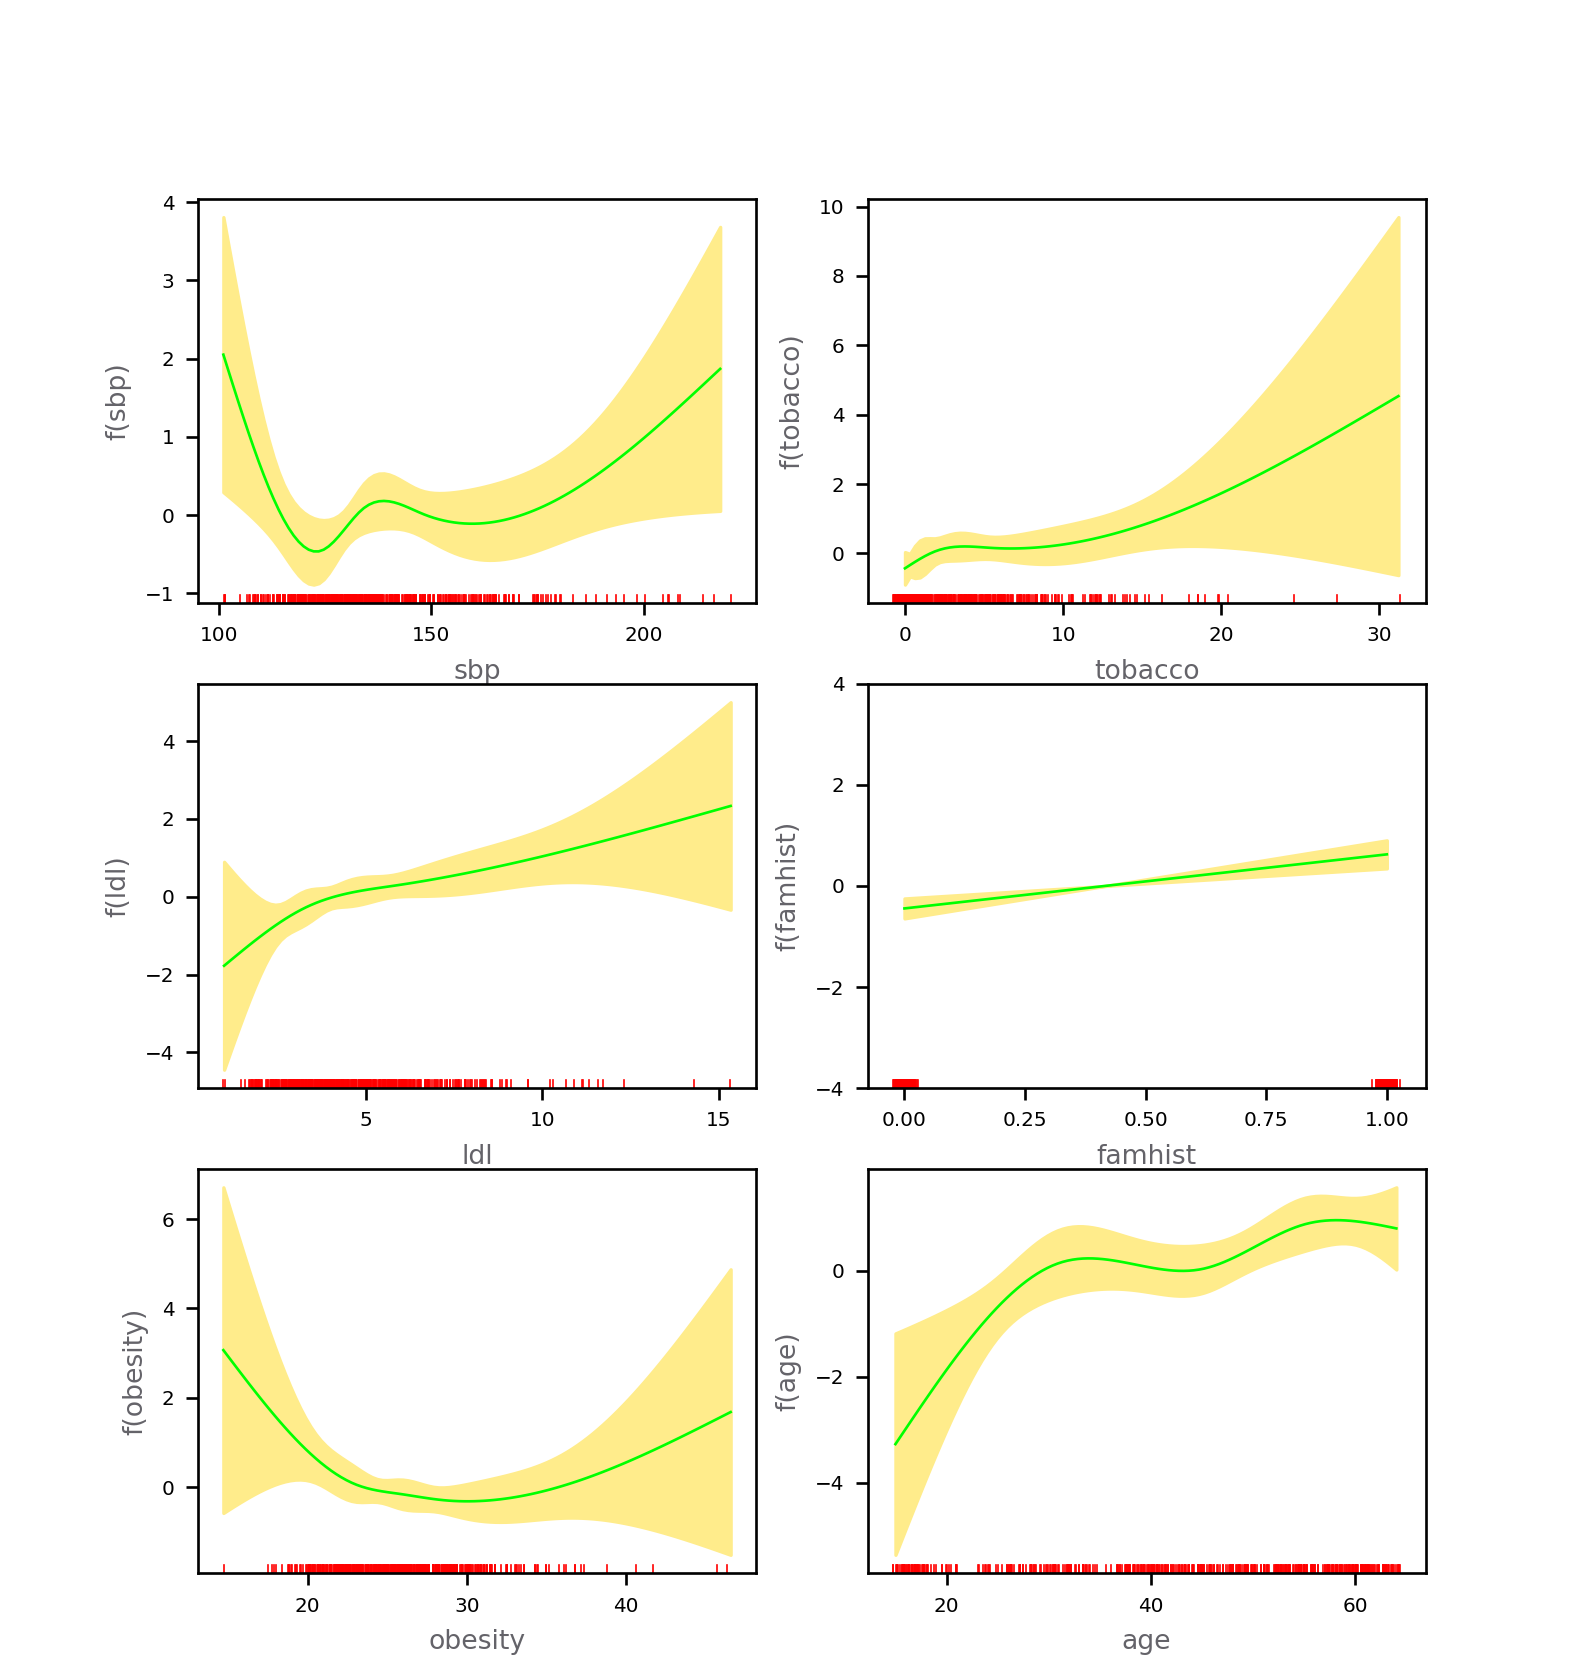

In [108]:
fig, axarr = plt.subplots(3, 2, figsize=(3.3*2, 2.3*3), dpi=150)
plt.subplots_adjust(bottom=0.05)
plot_term_natural_spline_function(axarr[0, 0], 0, 'sbp')
plot_term_natural_spline_function(axarr[0, 1], 1, 'tobacco')
plot_term_natural_spline_function(axarr[1, 0], 2, 'ldl')
plot_term_natural_spline_function(axarr[1, 1], 3, 'famhist', ylim=(-4, 4))
plot_term_natural_spline_function(axarr[2, 0], 4, 'obesity')
plot_term_natural_spline_function(axarr[2, 1], 5, 'age')